# Capstone Project: Predicting Telco Customer Churn

## Supervised Learning Project

This project is an independent study to determine what influences teleco customer churn. As an engineer in the telecommunications industry, I was naturally interested in doing a study of customer loyalty using various supervised learning models to best predict churn. In case you are not familiar with churn rate, it is also known as the rate of customer attrition. In other words, it is the percentage of exisitng customers cancelling their subscriptions during a given time period. In this case we are interested in whether the customer cancelled in the last month according to the dataset we are studying. The anonymized dataset that I am using is from Kaggle which you can find [here](https://www.kaggle.com/blastchar/telco-customer-churn).

The dataset has 7043 rows (customers) and 21 columns. 20 of those columns will be used as our features and the "Churn" column will be used as our target label.

### Featureset Details ###

* **customerID**: 7590-VHVEG (example)
* **gender**: Male or Female
* **SeniorCitizen**: Whether the customer is a senior citizen or not (1, 0)
* **Partner**: Whether the customer has a partner or not (Yes, No)
* **Dependents**: Whether the customer has dependents or not (Yes, No)
* **tenure**: Number of months the customer has stayed with the company
* **PhoneService**: Whether the customer has a phone service or not (Yes, No)
* **MultipleLines**: Whether the customer has multiple lines or not (Yes, No, No phone service)
* **InternetService**: Customer’s internet service provider (DSL, Fiber optic, No)
* **OnlineSecurity**: Whether the customer has online security or not (Yes, No, No internet service)
* **OnlineBackup**: Whether the customer has online backup or not (Yes, No, No internet service)
* **DeviceProtection**: Whether the customer has device protection or not (Yes, No, No internet service)
* **TechSupport**: Whether the customer has tech support or not (Yes, No, No internet service)
* **StreamingTV**: Whether the customer has streaming TV or not (Yes, No, No internet service)
* **StreamingMovies**: Whether the customer has streaming movies or not (Yes, No, No internet service)
* **Contract**: The contract term of the customer (Month-to-month, One year, Two year)
* **PaperlessBilling**: Whether the customer has paperless billing or not (Yes, No)
* **PaymentMethod**: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* **MonthlyCharges**: The amount charged to the customer monthly
* **TotalCharges**: The total amount charged to the customer


In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

In [2]:
# Load the Census dataset
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Display the first 5 records
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Evaluation: Preprocessing
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

In [3]:
# Verifying correct data types
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

As shown above `TotalCharges` is clearly the wrong data type. Let's change it to a float.

In [4]:
# Convert TotaCharges from object to numerical (float)
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')

In [5]:
# Count missing data
data.isna().sum().sum()

11

Since there are only 11 missing data points, the associated customer data will be removed from the dataset.

In [6]:
# Remove missing values
data.dropna(inplace = True)

# Remove customer IDs from the dataset since this data is not needed
data = data.drop('customerID', axis = 1)

## Data Evaluation: Check for skewed data or outliers
Outliers or skewed data can adversly affect machine learning models. If there are outliers in the dataset, we want to know about them. 

For highly-skewed feature distributions such as `'MonthlyCharges'` and `'TotalCharges'`, it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation because the logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

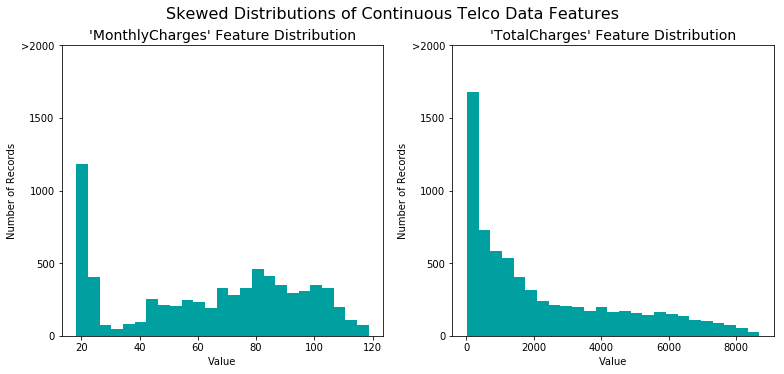

In [7]:
# Visualize skewed continuous features of original data
# credit: vs.py is a modification of code from the Udacity Project: Finding Donors for CharityML
vs.distribution(data)

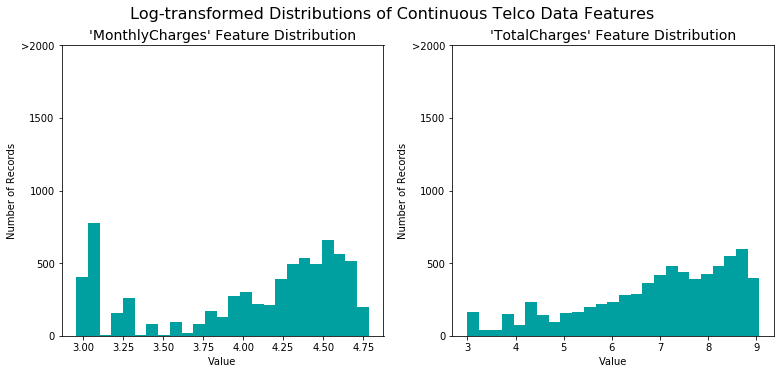

In [8]:
# Log-transform the skewed features
skewed = ['MonthlyCharges', 'TotalCharges']
data_log_transformed = data # copy data to features_log_transformed
data_log_transformed[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(data_log_transformed, transformed = True)

After looking at both sets of graphs, they do not reveal anything unusal about the data. There are no apparent outliers or anomalies. 

## Data Transformation: Numerical encoding

Let's replace the `Churn` values with numeric values so the ML models will be able to understand them.

In [9]:
# Convert 'Churn' data from text to binary numerical value
data_log_transformed['Churn'].replace(to_replace='Yes', value=1, inplace=True)
data_log_transformed['Churn'].replace(to_replace='No',  value=0, inplace=True)

We still have to address the other non-numerical values since the learning models do not know how to interpret them. Typically, machine learning models only do well with numerical information, so the best way to convert these non-numerical values into numbers is to use a one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category of each non-numeric feature. For example, assume we have a _customer-feature_ that could have a value of "A", "B", or "C". We then encode this feature into 3 separate features _customer-featureA_, _customer-featureB_, and _customer-featureC_.

In [10]:
# Convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(data_log_transformed)

# Show the transformed data
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,3.429137,3.429137,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,4.059581,7.544597,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,4.004602,4.692723,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,3.768153,7.518471,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,4.272491,5.028148,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


## Data Transformation: Normalizing Numerical Features
It is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `MonthlyCharges` or `TotalCharges`); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as shown below.

In [11]:
# Importing scaling tool
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']

normalized_df = df_dummies
normalized_df[numerical] = scaler.fit_transform(normalized_df[numerical])

# Show an example of a record with scaling applied
normalized_df.head()

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0.000000,0.258016,0.072892,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,0.464789,0.602917,0.749358,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,0.014085,0.572840,0.280590,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,0.619718,0.443484,0.745063,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,0.014085,0.719396,0.335724,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


## Shuffle and Split Data
Now that all numerical values have been normalized and all categorical features have been converted to numerical features, we must split the dataset into training and testing data for our machine learning models. For this project, 80% of the data will be used for training and 20% for testing.

In [12]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the data into features and target label
churn = normalized_df['Churn']
features_final = normalized_df.drop('Churn', axis = 1) # remove Churn from features data

# Split the features and labels data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    churn, 
                                                    test_size = 0.2, 
                                                    random_state = 31)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 5625 samples.
Testing set has 1407 samples.


## Evaluating Model Performance
Before we can intelligently evaluate a machine learning model's ability to predict churn, we need to establish a baseline metric or benchmark to measure against. Clearly we want to accurately predict potential customers that will cancel their telco services (True Positive) so that we can approach them with an incentive to keep their services. Intuitively, it is easy to believe the  higher the accuracy is better, however let's also consider a confusion matrix of possibilities. 

If the model falsely predicts a customer is about to churn (False Positive) and they do NOT it is not a huge loss to the telco company since the customer intends to keep their services but is perhaps offered a sweeter deal. If the model predicts that the customer will not churn and indeed they stay with the telco company (True Negative) there is no loss or gain here. However, if the model predicts the customer will NOT churn, but they DO churn (False Negative) then this is the biggest loss to the company because the company loses all revenue from that customer. False Negatives are the outcomes that we want to avoid the most! 

If our model produced a prediction accuracy of 95% we might be pretty happy with that outcome. This would mean that our model correctly predicts the customers who will churn and NOT churn with 95% accuracy. However, if the other 5% of our predictions fall into the False Negative category then the telco company will lose over 350 customers in this case because of false predictions. Because this outcome can be detrimental to the company, the model needs to be sensitive to False Negatives. We can do this with a metric known as recall, but measuring recall on it's own can have it's own problems. The F-score which takes into account precision and recall scores is probably the best measurement in this situation.

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of customers will churn and actually do churn. It is a ratio of true positives (customers that will churn and actually do churn) to all positives (all customers that are predicted to churn regardless if the classifier gets it right or wrong), in other words it is the ratio of 

`[True Positives/(True Positives + False Positives)]`

**Recall (AKA sensitivity)** tells us what proportion of customers that actually will churn were classified as churn. It is a ratio of true positives (customers that will churn and actually do churn) to all the customers that actually did churn, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

Taking into consideration the various metrics described above, the F1 score uses the harmonic mean (weighted average) of the precision and recall scores to produce a number between 0 and 1, with 1 being the highest F-score.

Let's return to the discussion of establishing a baseline measure that will give us a way to measure the performance of the metrics we will use later on. We can assume that none of the customers will churn without any data to backup our claim and we would be right more than 50% of the time, but if we make that assumption we will never identify any of the customers that WILL churn. This assumption would be naive and pointless. With that being said, if we made the assumption that all customers will churn then we would correctly identify every customer about to churn (100% True Positives), but at the cost of getting most predictions wrong (False Positives). This could be costly for the Telco, however we need to start somewhere to establish a measurable baseline. In the real world this step would probably not be necessary because of a previous model that has already established a baseline for you or some industry related research paper that could give you a starting point.

In [13]:
# Calculate accuracy, precision and recall
TN = 0 # initialize true negative
FN = 0 # initialize false negative
n_records = len(churn)
TP = np.sum(churn) # Counting the ones (churn=1) as this is the naive case.
FP = n_records - TP

accuracy = (TP + TN)/n_records
recall = TP/(TP + FN)
precision = TP/(TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision * recall)/((beta**2)*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2658, F-score: 0.3115]


The Naive Predictor will be our baseline with an accuracy and F-score as shown above.

### Calculating performance and cost

Now that we have a baseline, let's see how the results of other models compare to the baseline metrics. The code below will calculate the performance of the classifier and measure the cost (time to compute) for training and testing the model. It is good practice to use many different models to determine which model performs the best for the dataset you are working with.

In [14]:
# Importing two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score, f1_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: labels training set
       - X_test: features testing set
       - y_test: labels testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data 
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
    print("train time", results['train_time'])
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the training samples(X_train)
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the training samples
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = f1_score(y_test, predictions_test)
    
    # Success
    print("{} trained on {} samples. Test accuracy is {} and Test F-score is {}\n"
          .format(learner.__class__.__name__, sample_size, results['acc_test'], results['f_test']))
        
    # Return the results
    return results

## Supervised Learning Models

For this project I will compare the results of 3 supervised learning models. I will look at the training time, the accuracy score, and F-score on both the training set and testing set. I have chosen Random Forest, Logistic Regression and XGBoost models from `scikit-learn`.

#### Random Forest

* The strength of a Random Forest: it is very intuitive and simple to use. It provides interpretable predictions. It performs well on a large number of labeled features. It calculates results quickly and handles unbalanced and missing data well.
* The weakness of a Random Forest is that it tends to overfit on noisy data.
* Random Forest will be a good candidate for this problem because of the large number of features and it will provide insightful results that can be useful to target potential donors.

#### Logistic Regression

* The strength of Logistic Regression is the ability to predict binary outcomes such as yes or no (1 or 0). It can work on both linear and non-linear relationships between the input and output variables.
* The weakness of Logistic Regression is that performance decreases if the model has too many non-linear relationships. It does not adapt well to more complex situations. It must be tuned to avoid overfitting.
* Logistic Regression will be a good candidate for this problem since we are predicting a binary outcome (churn or no churn).

#### XGBoost

* The strength of XGBoost is its ability to make predictions fast and trains rather quickly. It is capable of handling sparse data whereas many other models do not handle this well. It can also be used across multiple processors to increase efficiency and reduce training time. It can handle structured and unstructured data. 
* The weakness of XGBoost is the fact that it can be difficult to determine the logic behind a prediction because of the use of several weak learners that are combined to produce a prediction. It also does not have deep analysis such that it truely understands the system of patterns that predict a result.
* XGBoost will be a good candidate for this problem because it works well with classification type problems.

## Implementation

The code below will create a training and predicting pipeline to experiment with the 3 different learning models listed above by measuring their prediction results and time to compute (cost). 

In [15]:
# Importing three supervised learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Initialize the three models
clf_A = RandomForestClassifier(random_state=31, n_estimators=10) # n_estimators given to silence warning
clf_B = LogisticRegression(solver='lbfgs', random_state=31) # default iterations=100, need more for convergence
clf_C = xgb.XGBClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100
# samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = int(0.1 * len(y_train))
samples_1 = int(0.01 * len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

D:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


train time 0.005983829498291016
RandomForestClassifier trained on 56 samples. Test accuracy is 0.7398720682302772 and Test F-score is 0.5569007263922519

train time 0.00797891616821289
RandomForestClassifier trained on 562 samples. Test accuracy is 0.7718550106609808 and Test F-score is 0.48309178743961345

train time 0.04787325859069824
RandomForestClassifier trained on 5625 samples. Test accuracy is 0.7775408670931059 and Test F-score is 0.5147286821705427

train time 0.003989458084106445
LogisticRegression trained on 56 samples. Test accuracy is 0.697228144989339 and Test F-score is 0.5534591194968554

train time 0.014960527420043945
LogisticRegression trained on 562 samples. Test accuracy is 0.783226723525231 and Test F-score is 0.5534407027818448

train time 0.04089069366455078
LogisticRegression trained on 5625 samples. Test accuracy is 0.8038379530916845 and Test F-score is 0.5830815709969788

train time 0.06682395935058594
XGBClassifier trained on 56 samples. Test accuracy is 0

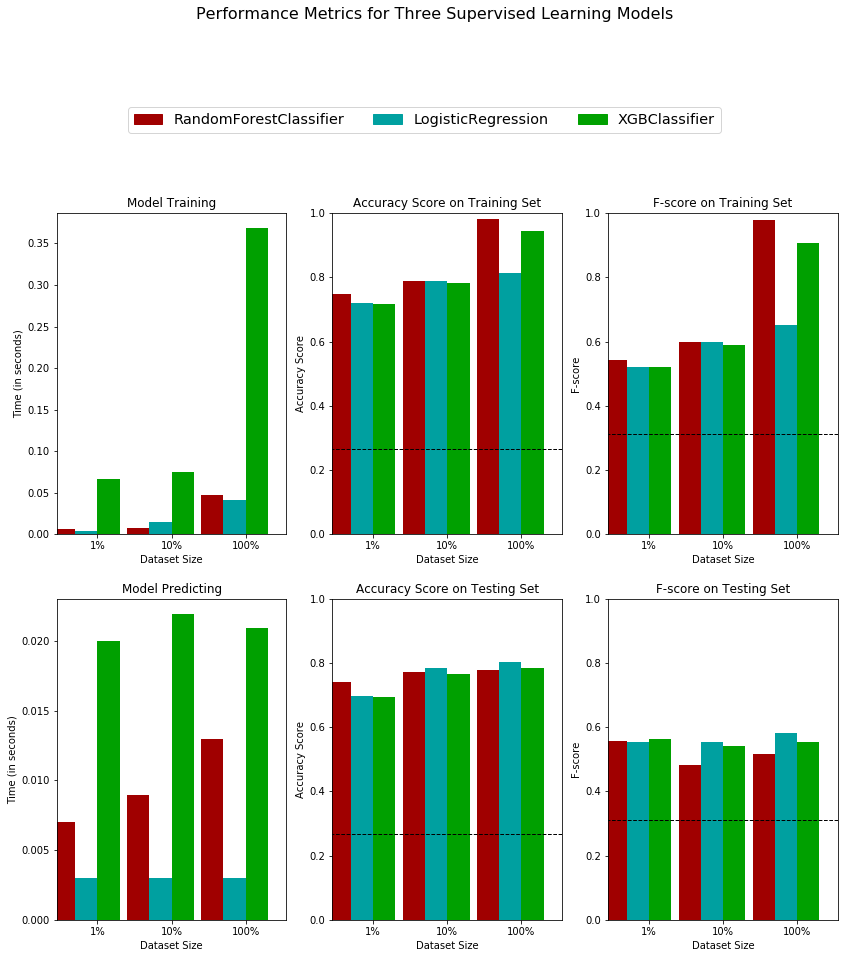

In [16]:
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

## Reviewing results

For this problem Logistic Regression was chosen as the winner. It was significantly faster at training than XGBoost. It also made predictions faster than Random Forest and XGBoost. Logistic Regression scored the highest on accuracy and F1 score when predicting results on 100% of the test data. Clearly none of the models took a very long time to train or test, but if we were looking at data from a large telco business then we could be running these classifiers on millions of customer records which could take a lot longer.

## Understanding Logisitic Regression
To understand how Logistic Regression is done, you must visualize the dataset as points suspended in a multi-dimensional space. Each point is respresented by the features given from the dataset. For example, gender, tenure, PhoneService, MonthlyCharges, TotalCharges, etc are used to calculate the position of a point in a multi-dimensional space. Logistic Regression then tries to separate all points into 2 categories by drawing a line or plane between the two groups of points.

For this particular problem, the model will begin to separate the points to answer the question, "Will the customer churn?" For Logistic Regression the answer must be binary. That is to say, it can only be one of two choices: "yes" or "no". Using a portion of the dataset for training, the classifier makes an arbitrary stab at trying to separate the data into "yes" or "no" groups for potential churn. The classifier then evaluates itself on it's initial guess by looking at the "answer" to see if it categorized each point to the true results that is provided in the training set. Through multiple iterations the classifier continues to make slight adjustments to the separating plane so that it reaches the maximum likelihood estimation. In other words, the classifier stops making adjustments when it reaches the best percentage of correctly categorized points for both "yes" and "no" groups.

Using what the model learns from the training set, the model applies that learning to the testing set to see how it would perform on data it has not yet seen. Various tools can then measure and evaluate the outcome of the testing set and provide a numerical results that gives the user a sense of how confident the model will do with new data in the real world.



## Tuning Results

The 3 models that I used were taken "straight out the box" as a manner of speaking, that is I did not tune any of the parameters. Let's see if we can fine tune the Logistic Regression model by using a grid search of various parameters. The grid search tool does an exhaustive analysis of all paramaters that are given by the user in order to find the combination of parameters that produces the best results. 

In [17]:
# Importing metrics
from sklearn.metrics import fbeta_score, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV

def tuning_results(X_train, y_train, X_test, y_test):
    '''
    inputs:
       - X_train: features training set
       - y_train: labels training set
       - X_test: features testing set
       - y_test: labels testing set
    '''
    # Initialize the classifier
    clf = LogisticRegression()

    # Using a variety of parameters to find the best results
    parameters = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'],
                  'multi_class': ['auto', 'ovr'],
                  'max_iter': [200, 400, 800, 1200],
                  'random_state': [31]}

    # Using fbeta_score scoring object for make_scorer()
    scorer = make_scorer(fbeta_score, beta=0.5)

    # Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=5)
 
    # Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)

    # Report the before-and-afterscores
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    print("Classification Report\n",classification_report(y_test,predictions))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
    print("Classification Report\n",classification_report(y_test, best_predictions))
    
    return best_clf, best_predictions

In [18]:
best_clf, best_predictions = tuning_results(X_train, y_train, X_test, y_test)

Unoptimized model
------
Accuracy score on testing data: 0.8038
F-score on testing data: 0.6287
Classification Report
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.66      0.52      0.58       371

   micro avg       0.80      0.80      0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.80      1407


Optimized Model
------
Final accuracy score on the testing data: 0.8038
Final F-score on the testing data: 0.6287
Classification Report
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.66      0.52      0.58       371

   micro avg       0.80      0.80      0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.80      1407



D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Comparing Results
Unfortunately running through an exhaustive list of tuning parameters using the grid search tool did not produce any better results than using the Logisitic Regression classifier straight out of the box. This is disappointing, but perhaps a bigger dataset may have provided more training for the classifier to improve the final results.

Do not dispair! The Receiver Operating Characteristic (ROC) curve will be the final measurement to determine how well the best selected model is performing. If the area under the curve (AUC) is 0.5 then the model failed to distinguish between 
customers that will churn vs no churn. In other words, it makes 50% right and 50% wrong predictions which is not helpful. 
Below is a general rule for AUC ratings:

• AUC: 0.5 (failed)<br />
• AUC: 0.7 – 0.8 (good)<br />
• AUC: 0.8 – 0.9 (excellent)<br />
• AUC: 0.9+ (outstanding)<br />

In [19]:
from sklearn import metrics

# Calculate False Positive Rate (FPR) and True Positive Rate (TPR) on test set
fpr, tpr, thresholds = metrics.roc_curve(y_test, best_predictions) 

# Calculate AUC
print('AUC: {}'.format(metrics.auc(fpr, tpr)))

AUC: 0.712810519414293


As shown above, the AUC is 0.71 which is good, but I have a hunch it would be a lot better if we had a bigger dataset to work with. Below is a graph of the ROC Curve.

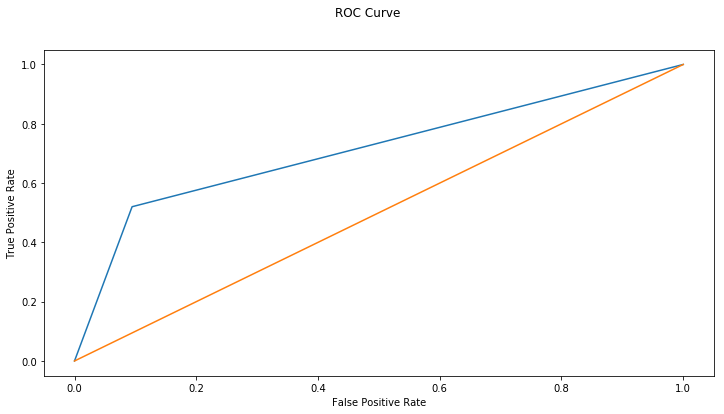

In [20]:
# Plot the FPR and TPR
plt.figure(figsize = (12,6))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1]) # Plot positive sloped 1:1 line for reference
plt.suptitle('ROC Curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");

## Feature Importance
An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target labels we simplify our understanding of the features that drive a customer to churn. This is helpful to better understand the data we are working with. In the case of this project, we will identify a small number of features that most strongly influence customer churn through `feature_importance_`. Keep in mind we increased the number of features in the dataset from 20 to 45 when did one-hot encoding earlier. However, before we look at feature importance let's do some simple correlation analysis.

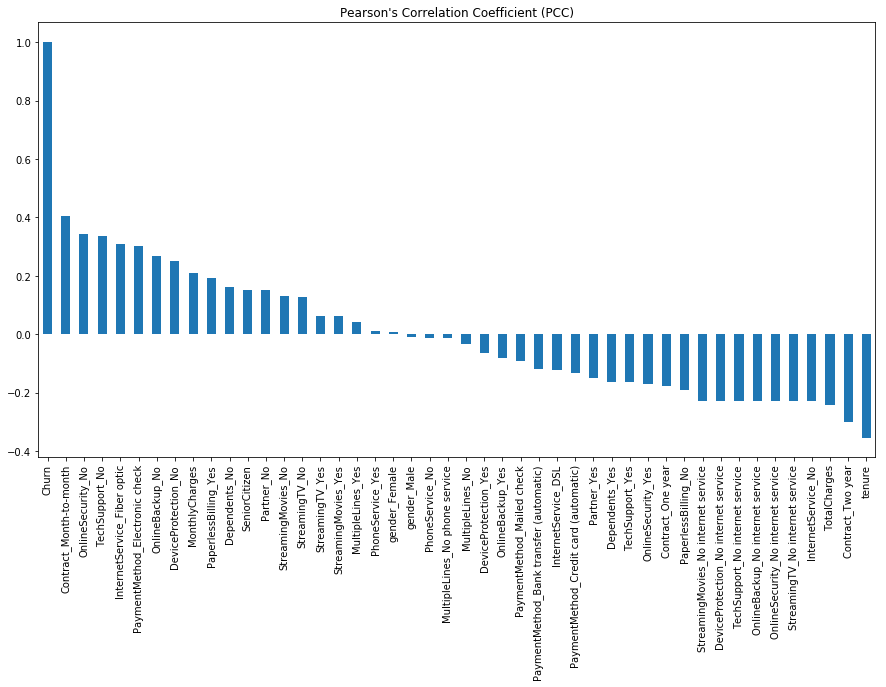

In [21]:
# Correlation graph of all categorical features
# credit: https://stackoverflow.com/questions/40902958/pandas-dataframe-bar-plot-with-sort-values-by-other-column
plt.figure(figsize=(15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar', title="Pearson's Correlation Coefficient (PCC)");

In this correlation graph, we calculate Pearson's correlation coefficient which is the covariance of two features (`Churn` and another feature) divided by the product of their standard deviations which results in a number between -1 and 1. We find that `tenure`, `Contract_Two year`, and `TotalCharges` help reduce churn. On the other hand, `Contract_Month-to-month` increases churn which we would expect to see. We also see `OnlineSecurity_No` and `TechSupport_No` might increase churn. However, let's dig deeper by turning our attention to the feature importance provided by our models.

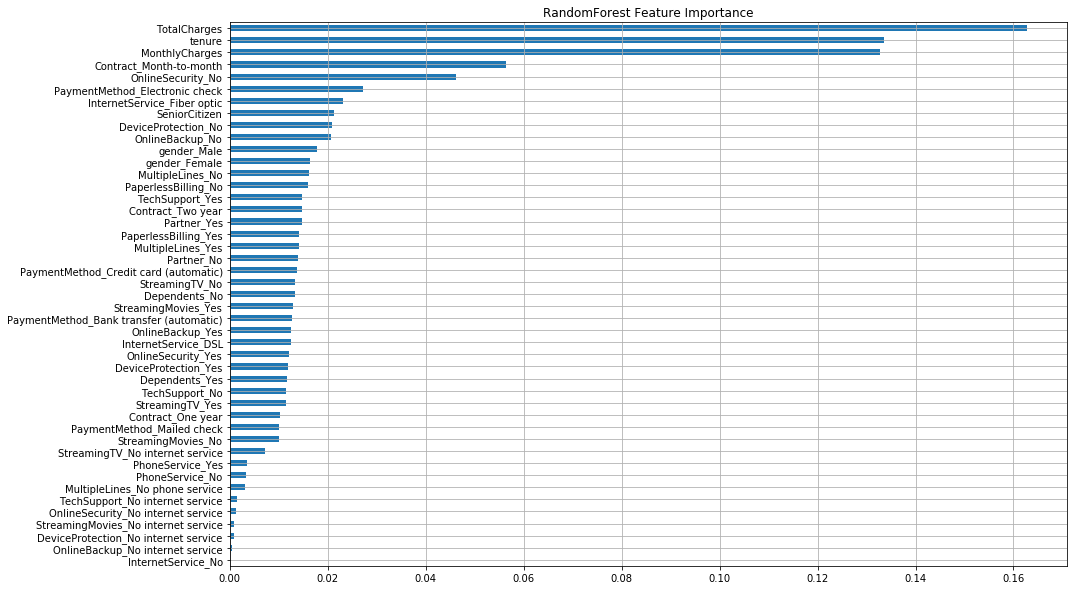

In [22]:
# RandomForest Feature Importance
importances = clf_A.feature_importances_ # extract feature importances
weights = pd.Series(importances, index=features_final.columns.values)
weights.sort_values()[:].plot(kind = 'barh', title='RandomForest Feature Importance', figsize=(15, 10));
plt.grid()

From the RandomForest model, we see that `TotalCharges`, `tenure`, `MonthlyCharges`, and `Contract_Month-to-month` have the most influence on churn with respect to all other features. We also see that `OnlineSecurity_No` makes into the top 5 most influential features just like the PCC graph shown before.

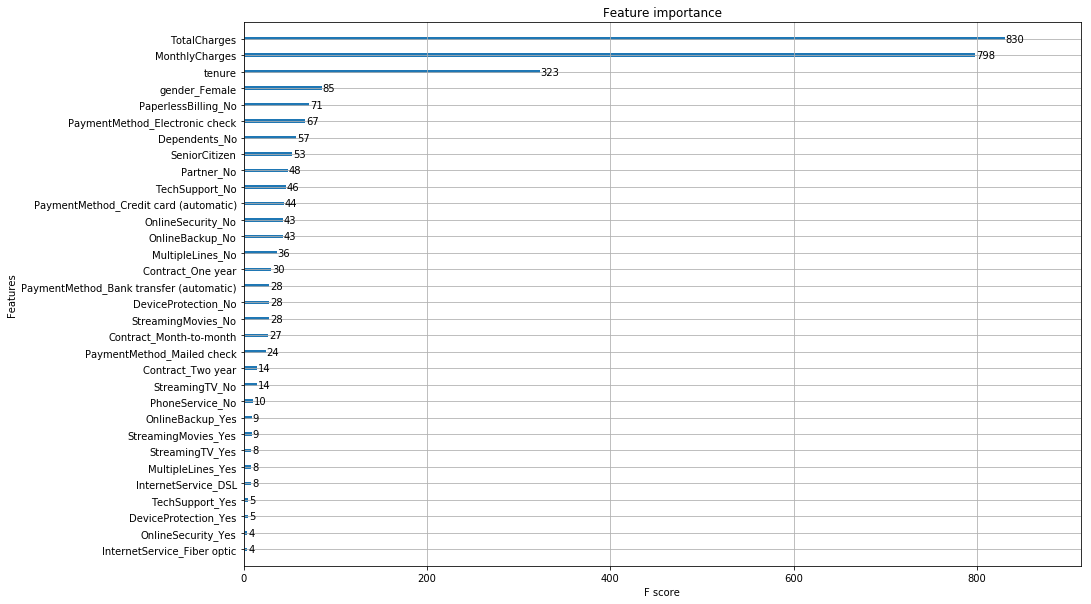

In [24]:
# XGBoost Feature Importance
xgb.plot_importance(clf_C).plot(kind = 'bar', figsize = (15,10));
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

From the XGBoost model, we see that this model largely agrees with the RandomForest model when comparing the top 3 most influential features that affect churn. It appears that it is only these 3 that make the most notable impact.

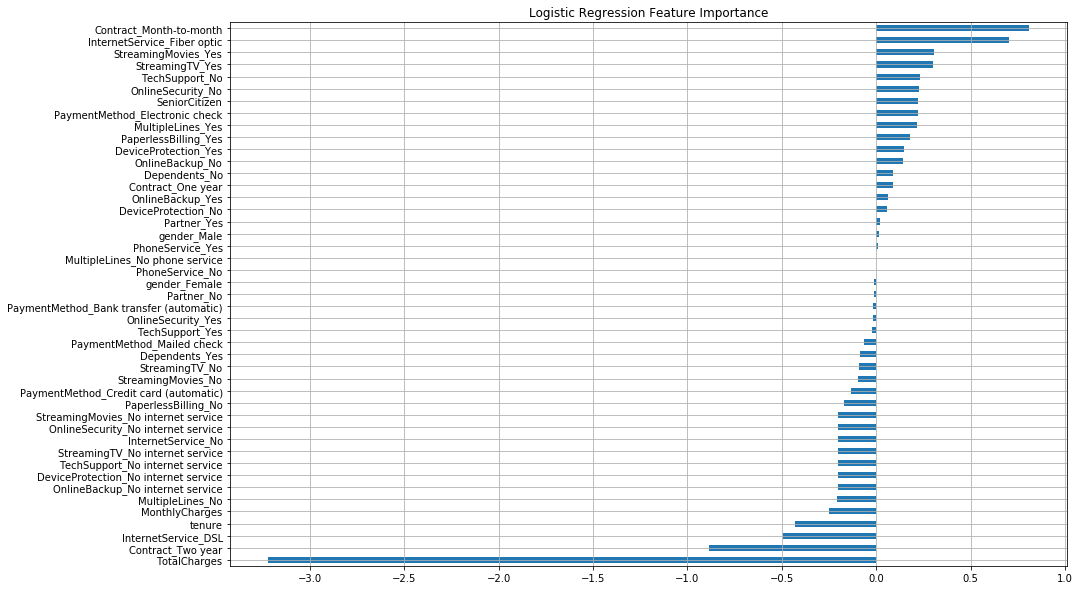

In [25]:
# Logistic Regression Feature Importance
importances = clf_B.coef_[0] # extract feature importances
weights = pd.Series(importances, index=features_final.columns.values)
weights.sort_values()[:].plot(kind = 'barh', title='Logistic Regression Feature Importance', figsize=(15, 10));
plt.grid()

From the Logistic Regression model, we see that `Contract_Month-to-month` and `InternetService_Fiber optic` increases churn whereas, `TotalCharges` and `Contract_Two year` largely reduces churn. We should note that `TotalCharges`, `tenure` and `MonthlyCharges` are in the top 5 influencers in reducing churn which complements what we found in the other models. Intuitively the features that reduce churn and increase churn make sense. What we discover is that `InternetService_DSL` is a surprise factor in reducing churn and `InternetService_Fiber optic` is a surprise factor in increasing churn! These two features are closely related in that they are types of internet service, but it is interesting how each could have a polar opposite affect on churn. Fiber optic service would be extremely fast and DSL might be slow to moderate speed. Perhaps the cost of fiber optic service is much more than DSL. Perhaps the reliability of one service is far better than the other. This would require some further investigation by the sales/marketing team and IT department.

## Principal Component Analysis (PCA)

Next we will look at Principal Component Analysis (PCA) which is a method to reduce the number of features by creating "principal components". The method tries to find many similar or redundant features and combines them to create a new feature set which has fewer features than the original dataset. This method uses a linear transformations of features which is projected onto a reduced PCA space and captures the largest variances in the data without discarding any data.

In [26]:
# Importing PCA from sklearn
from sklearn.decomposition import PCA

pca = PCA() # Initialize classifier using all 45 features
pca_45 = pca.fit(X_train) # fit to data
X_pca_45 = pca_45.transform(X_train) # transform data

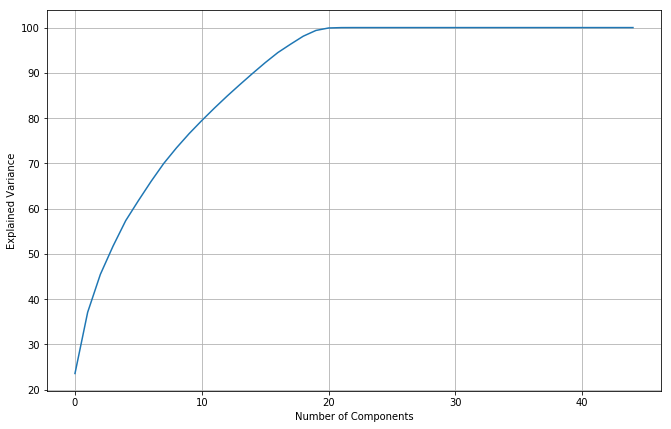

In [27]:
fig = plt.figure(figsize = (11,7))
plt.grid()
plt.plot(np.cumsum(pca_45.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance');

From the graph above we can see that 80% of the explained variance is around the top 10 components.

In [28]:
# Print the percentages of the top components
top_components = pca_45.explained_variance_ratio_[np.cumsum(pca_45.explained_variance_ratio_) <= .80]
list(top_components * 100)

[23.5871974485649,
 13.518806567757146,
 8.368628927462,
 6.241726461799135,
 5.635000357075894,
 4.415634734443068,
 4.251456050918696,
 3.972128748892765,
 3.429475528303493,
 3.1483733377955008,
 2.8952448471289505]

In the list printed above, we see that the first principal component explains the largest variance at 23.6%, followed by the second PC at 13.5%, and so on. However, the data by itself is not helpful. We need to look at the features that comprise these components.

In [29]:
import seaborn as sns

def display_component(data, features_list, component_num, n_weights=10):
    ''' credit: This function was modified from the Pop Segmentation Case Study within this course
    inputs:
       - data: dataframe of pca.components_ 
       - features_list: list of all 45 feature names
       - component_num: integer value of a principal component
       - n_weights: integer value of total # of weights and respective feature to be shown    
    '''
    
    # get index of component (all_features - component_num)
    row_idx = pca_45.n_features_ - component_num

    # get the list of weights from a row in the dataframe
    d_1_row = data.iloc[:, row_idx]
    d_1 = np.squeeze(d_1_row.values)

    # match weights to features in dataframe, using list comprehension
    comps = pd.DataFrame(list(zip(d_1, features_list)), columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("Principal Component #" + str(component_num))
    plt.show()

Let's take a look at the first 3 principal components to see what they look like.

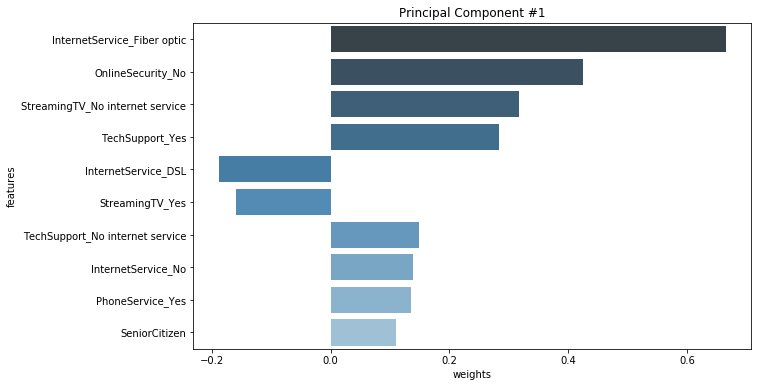

In [30]:
# display makeup of first component
num=1
display_component(pd.DataFrame(pca_45.components_), features_final.columns.values, component_num=num, n_weights=10)

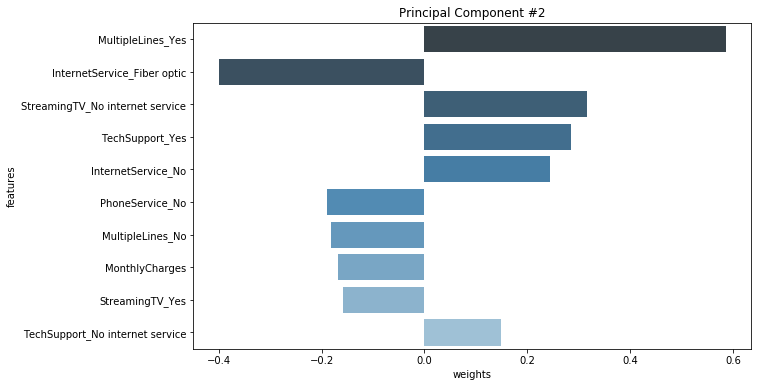

In [31]:
# display makeup of second component
num=2
display_component(pd.DataFrame(pca_45.components_), features_final.columns.values, component_num=num, n_weights=10)

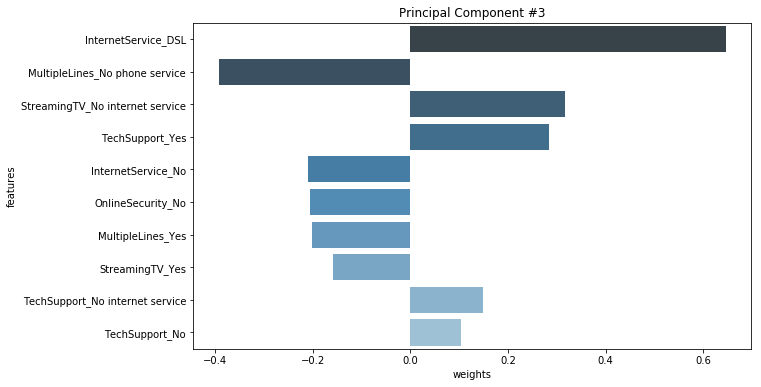

In [32]:
# display makeup of third component
num=3
display_component(pd.DataFrame(pca_45.components_), features_final.columns.values, component_num=num, n_weights=10)

Once again we see that `InternetService_DSL` and `InternetService_Fiber optic` standout as big influencers in all 3 PCs. There may be some further correlation with `StreaminTV_No internet service` and `TechSupport_Yes`.

## Conclusion

We have made some interesting discoveries using various machine learning models and methods to analyze this dataset. Now that we are empowered with this knowledge we can present this data to upper management and to our sales, marketing, and technology teams to get their input on these correlations and influencers. Using this knowledge we can begin a targeted effort to decrease churn or even better, prevent churn before it happens!